# Dark Matter Substructure from Strong Lenses

*Contact: Alex Drlica-Wagner*

This notebook is an attempt to replicate the likelihood analysis framework of [Vegetti & Koopmans, 2009 (VK09)](https://arxiv.org/abs/0903.4752) to constrain the dark matter substructure fraction, $f$, and the index of the dark matter power spectrum, $\alpha$, from a statistical sample of strong lens systems. The analysis of VK09 focuses on building a joint likelihood function for analysing a sample of strong lense systems sim

1. The substructure mass fraction and the index of the substructure mass function are the same in all lens systems. This assumption is manifest by tying the $\alpha$ and $f$ parameters across all lenses.
2. The characteristics of the dark matter substructure are independent of radial position in the lens. In reality, we are only measuring the substructure characteristics close to the Einstein radius, $R_{E}$.
3. Sustructures are independent random variates within each lens (i.e., no 2-halo term) and between lenses.

All equation numbers in this document correspond to the equation numbering in the [published version](https://academic.oup.com/mnras/article-lookup/doi/10.1111/j.1365-2966.2009.15559.x) of VK09.

In [1]:
# General imports
%matplotlib inline

import logging
import numpy as np
import pylab as plt
from scipy import stats
from scipy import integrate
from scipy.integrate import simps,trapz,quad,nquad
from scipy.interpolate import interp1d
from scipy.misc import factorial

## Constants and Defaults

We start by defining several constants and defaults. Specifically, we are interested in the following parameters:

* $(M_{\rm min},\ M_{\rm max}$ = `(MMIN,MMAX)`: The minimum and maximum masses of the underlying true substructure mass function.
* $(M_{\rm low},\ M_{\rm high})$ = `(MLOW,MHIGH)`: The low and high mass ends of the observable section of the substructure mass function.
* $\vec{p}$ = `P` = `(MMIN,MMAX,MLOW,MHIGH)`: The set of nuisance parameters describing the mass limits.
* $\alpha$ = `ALPHA`: The slope of the substructure mass function (`default: 1.9`)
* $f$ = `FRAC`: The substructure mass fraction (`default: 0.02`) 
* $M(<R)$ = `MHALO`: The host halo mass (`default: 1e11`)
* $\sigma_{m}$ = `SIGMA`: Mass measurement error (or intrinsic spread)

In [2]:
# Constants
MMIN,MMAX  = 4e6,4e9
MLOW,MHIGH = 0.3e8,4e9
P = (MMIN,MMAX,MLOW,MHIGH)
NSTEPS=(1000,1000)

# Defaults                                                                          
ALPHA=1.9
FRAC=0.02
MHALO=1e11
SIGMA = 0

In [3]:
# Utility functions

def create_mass_array(log=True,nsteps=(1500,1300)):
    """ Create an array spanning the true and observable mass ranges.                
                                                                                     
    Parameters:                                                                      
    -----------                                                                      
    p      : Tuple of the range of masses (MMIN,MMAX,MHIGH,MLOW)                     
    nsteps : Number of steps to span the ranges (NTRUE, NCONV)                       
    log    : Sample in log or linear space                                           
                                                                                     
    Returns:                                                                         
    --------                                                                         
    m,mp,mm,mmp : The                                                                
    """
    nsteps = map(int,nsteps)
    if log:
        m = np.logspace(np.log10(MMIN),np.log10(MMAX),nsteps[0])
        mp = np.logspace(np.log10(MLOW),np.log10(MHIGH),nsteps[1])
    else:
        m = np.linspace(MMIN,MMAX,nsteps[0])
        mp = np.linspace(MLOW,MHIGH,nsteps[1])
    mm,mmp = np.meshgrid(m,mp)
    return m,mp,mm,mmp

def mhalo(radius=None):
    """ Return the halo mass as a function of maximum radius.                        
    WARNING: Returns constant MHALO independent of R!                                
                                                                                     
    Parameters:                                                                      
    -----------                                                                      
    radius : Maximum radius for inclused halo mass                                   
                                                                                     
    Returns:                                                                         
    --------                                                                         
    mhalo : Enclosed halo mass                                                       
    """
    return MHALO

## Subhalo Mass Function

The true subhalo mass function is assumed to be a normalized power-law with index $\alpha$

\begin{equation}
\left.\frac{dP}{dm}\right|_{true}=\left\{
 \begin{array}{cc}
 \frac{\left(1-\alpha\right)~m^{-\alpha}}{ \left(M_{\rm{max}}^{1-\alpha}~-~M_{\rm{min}}^{1 -\alpha}\right)}& \alpha \neq 1\\
\\
 \frac{m^{-\alpha}}{ \log{\left(M_{\rm{max}}/M_{\rm{min}}\right)}}& \alpha = 1 
\end{array}
	\right.
\tag{6}
\end{equation}

VK09 convolve this true mass function with a Gaussian to account for "the presence of noise on the data and the statistical uncertainty with which masses are measured". They define their convolved mass function as

\begin{equation}
\left. \frac{dP}{dm} \right|_{conv} = \int_{M_{\rm{min}}}^{M_{\rm{max}}} {\left.\frac{dP}{dm}\right |_{true}} \frac{e^{-\left(m-m^\prime\right)^2/2{\sigma^2_m}}}{\sqrt{2\pi}\sigma_m} ~dm
\end{equation}

NOTE: I'm not sure I completely believe this motivation for the convolved mass function. What they have done is to incorporate an *intrinsic* scatter in the true mass function. This has the effect that occasionally masses below the detection threshold will scatter *up* to detectability. I don't think that this is an accurate representation of the effect of measurement error, but I'd need to think about it a bit more.

NOTE: When the mass uncertainty is zero, $\sigma_m = 0$, then the Gaussian convolution is replaced with at $\delta$-function and the convloved mass function reverts to the true mass function.

In [4]:
def dP_dm_true(m,alpha):
    """ True mass function (Eqn. 6) normalized over full mass range [MMIN,MMAX].
    
    Parameters:
    ---------- 
    m     : True mass of subhalo
    alpha : Power-law index of subhalo mass function

    Returns:
    --------                                               
    dP_dm_true : Normalized pdf                                                      
    """
    m = np.atleast_1d(m)
    ret = ((1-alpha)*m**(-alpha))/(MMAX**(1-alpha)-MMIN**(1-alpha))
    ret = np.where(alpha==1,(m**-alpha)/np.log(MMAX/MMIN),ret)
    return np.where(np.isfinite(ret),ret,np.nan)

def dP_dm_conv(m,mp,alpha,sigma=SIGMA):
    """ The convolved mass function.
                                                                                     
    Parameters:                                                                      
    -----------                                                                      
    m   : The range of true masses                                                   
    mp  : The range of observed masses                                               
                                                                                     
    Returns:                                                                         
    --------                                                                         
    dP_dm_conv : The integrated convolved mass function                              
    """
    if sigma == 0:
        # Convolution replaced with delta function when sigma == 0
        return dP_dm_true(np.atleast_2d(mp.T)[0],alpha)
    else:
        return simps(dP_dm_true(m,alpha)*stats.norm.pdf(m,loc=mp,scale=sigma),m)

## Substructure Likelihood Function

VK09 define the likelihood of detecting $n_s$ substructures, each with mass $m_i$, in a single galaxy as the product of the Poisson probability of detecting $n_s$ substtimes the normalized probability density of observing a substructure with mass $m_i$ within a radius $R$,
    
\begin{equation}
{\cal L}\left( n_s,\vec{m}~|~\alpha,f,\vec{p}\right) = \frac{e^{-\mu(\alpha,f,< R)}~{\mu(\alpha,f,< R)}^{n_s}}{n_s!}  \times \prod_{i=1}^{n_s}P\left(m_i,R~|~\vec{p},\alpha\right)\,.
\tag{1}
\end{equation}

Assuming that the probability of observing a substructure is independent of $R$, the normalized probability density of observing the masses $m_i$ can be expressed as

\begin{equation}
P\left(m_i~|~\vec{p},\alpha\right) = \frac{\int_{M_{\rm{min}}}^{M_{\rm{max}}}{\left. \frac{dP}{dm}\right|_{true}\frac{e^{-\left(m-m_i\right)^2/2{\sigma_m}^2}}{\sqrt{2\pi}\sigma_m} dm}}{\int_{M_{\rm{low}}} ^{M_{\rm{high}}} { \int_{M_{\rm{min}}} ^{M_{\rm{max}}} {\left.\frac{dP}{dm}\right|_{true}}\frac{e^{-\left(m-m^\prime\right)^2/2{\sigma_m}^2}}{\sqrt{2\pi}\sigma_m} ~dm~dm^\prime}}\,.
\tag{2}
\end{equation}


In turn, the probability of measuring $n_s$ substructures in each of $n_l$ lenses, is the product of the likelihoods for each individual lens,

\begin{equation}
{\cal L}\left( \{n_s,\vec{m}\}~|~\alpha,f,\vec{p} \right) = \prod_{k=1}^{n_l}{\cal L}\left( n_{s,k},\vec{m}_k~|~\alpha,f,\vec{p} \right)\,.
\tag{8}
\end{equation}  

It is easier (and more numerically accurate) to work with the logarithm of the likelihood:

\begin{align}
\log{\cal L}\left( \{n_s,\vec{m}\}~|~\alpha,f,\vec{p} \right) &= \sum_{k=1}^{n_l}{\log \cal L}\left( n_{s,k},\vec{m}_k~|~\alpha,f,\vec{p} \right)\\
&= \sum_{k=1}^{n_l} \log \left( \frac{e^{-\mu(\alpha,f,< R)}~{\mu(\alpha,f,< R)}^{n_s}}{n_s!} \right)  + \sum_{k=1}^{n_l} \sum_{i=1}^{n_s} \log P\left(m_i,R~|~\vec{p},\alpha\right)
\end{align}  

The likelihood is clearly separable into two terms:
1. The first term represents the probability of having the measured abundance of subhalos. We call this term the "abudance probability" or $LogProb(N)$.
2. The second term represnts the probability of measuring a given mass for each subhalo. We call this term the "mass probability" or $LogProb(m)$.

We describe the two terms in more detail below.

## Abundance Probability 

The first term represents the Poisson probability of detecting $n_s$ substructures when $\mu(\alpha,f,< R)$ are expected.

\begin{equation}
LogProb(N) = \sum_{k=1}^{n_l} \log \left( \frac{e^{-\mu(\alpha,f,< R)}~{\mu(\alpha,f,< R)}^{n_s}}{n_s!} \right) 
\end{equation}

The expected number of substructures is calculated from the mass function and the detectable range. First we define the expectation over the full mass range

\begin{align}
	\mu_0(\alpha,f,<R,\vec{p}) &= \frac{ f(<R)~ M_{\rm{DM}}(<R)} {\int_{M_{\rm{min}}}^{M_{\rm{max}}}{m~\left.\frac{dP}{dm}\right |_{true}~dm}} \\
    &= f(<R)~M_{\rm{DM}}(<R)\left\{
	\begin{array}{ccc}
	\frac{ \left(2 -\alpha\right)~ \left(M_{\rm{max}}^{1-\alpha}~-~M_{\rm{min}}^{1 -\alpha}\right)} {\left(1 -\alpha \right)~ \left(M_{\rm{max}}^{2 -\alpha}~-~M_{\rm{min}}^{2 -\alpha}\right)} & \alpha \neq 2,~ \alpha \neq 1\\
	\\
	-\frac{\left(M_{\rm{max}}^{-1}~-~M_{\rm{min}}^{-1}\right)} {\log\left(M_{\rm{max}}~/~M_{\rm{min}}\right)} & \alpha = 2\\
	\\
	\frac{\log{\left(M_{\rm{max}} / M_{\rm{min}}\right)}} { \left(M_{\rm{max}}~-~M_{\rm{min}}\right)} & \alpha =1 &\\
	\end{array}
	\right.
    \tag{5}
\end{align}

Then we calculate the expectation value for the convolved mass function over the detectable range

\begin{align}
\mu(\alpha,f,<R,\vec{p}) &= \mu_0(\alpha,f,<R,\vec{p}) \int_{M_{\rm{low}}} ^{M_{\rm{high}}} { \left. \frac{dP}{dm}\right |_{conv}~dm} \\
&= \mu_0(\alpha,f,<R,\vec{p}) \int_{M_{\rm{low}}} ^{M_{\rm{high}}} { \int_{M_{\rm{min}}} ^{M_{\rm{max}}} {\left.\frac{dP}{dm}\right |_{true}}\frac{e^{-\left(m-m^\prime\right)^2/2{\sigma^2_m}}}{\sqrt{2\pi}\sigma_m} ~dm~dm^\prime}\,.
\tag{7}
\end{align}

We can then put everything together to define abundance probability function, $LogProb(N)$.

In [5]:
def mu0(alpha, frac, radius=None):
    """ Expected number of substructures from the true mass function (Eq. 5).        
                                                                                     
    Parameters:                                                                      
    -----------                                                                      
    alpha : Slope of the substructure mass function                                  
    frac  : Substructure mass fraction                                               
    radius: Enclosed radius                                                          
                                                                                     
    Returns:                                                                         
    --------                                                                         
    mu0   : Predicted number of substructures for the true mass function             
    """
    alpha = np.atleast_1d(alpha)
    integral = ( (2-alpha)*(MMAX**(1-alpha) - MMIN**(1-alpha))) / \
               ( (1-alpha)*(MMAX**(2-alpha) - MMIN**(2-alpha)))
    integral = np.where(alpha==2,-(MMAX**-1 - MMIN**-1)/np.log(MMAX/MMIN),integral)
    integral = np.where(alpha==1,np.log(MMAX/MMIN)/(MMAX - MMIN),integral)
    return frac * mhalo(radius) * integral

def mu(alpha, frac, radius=None, sigma=SIGMA):
    """ Expected number of substructures from the observable mass function (Eq. 4)   
                                                                                     
    Parameters:                                                                      
    -----------                                                                      
    alpha : Slope of the substructure mass function                                  
    frac  : Substructure mass fraction                                               
    radius: Enclosed radius                                                          
    sigma : Substructure mass error                                                  
                                                                                     
    Returns:                                                                         
    --------                                                                         
    mu   : Predicted number of substructures for the observable mass function        
    """
    m,mp,mm,mmp = create_mass_array()
    _mu0 = mu0(alpha, frac, radius)
    _integral = simps(dP_dm_conv(mm,mmp,alpha,sigma=sigma),mp)
    return _mu0 * _integral

def LogProbNumber(data, alpha, frac, R=1, sigma=SIGMA):
    """ Logarithm of the joint probability for the number of substructures.          
                                                                                     
    Parameters:                                                                      
    -----------                                                                      
    data : Input data                                                                
    alpha: Index of the mass function                                                
    frac : Substructure mass fraction                                                
                                                                                     
    Returns:                                                                         
    --------                                                                         
    prob : Logarithm of the joint Poission probability                               
    """
    logging.debug(' LogProbNumber: %s'%len(data))
    nsrc = data['nsrc']
    _mu = mu(alpha,frac,R,sigma=sigma)
    return np.sum(stats.poisson.logpmf(nsrc[:,np.newaxis],_mu),axis=0)

## Mass Probability

The second term is a Gaussian probability for measuring a subhalo with mass $m_i$

\begin{align}
Prob(m) = \sum_{k=1}^{n_l} \sum_{i=1}^{n_s} \log P\left(m_{k,i} ~|~\vec{p},\alpha \right)
\end{align}

The denominator in Eq 2 does not depend on any specific substructure, $m_i$, and can therefore be extracted from the sum. Additionally, since $\alpha$ and $f$ are assumed to be the same in all lenses, the double sum can be simplified to a single sum over all substructures. The mass probability function therefore becomes

\begin{align}
Prob(m) &= \sum_{j=1}^{n_l \times n_s} \log \int_{M_{\rm{min}}}^{M_{\rm{max}}}{\left. \frac{dP}{dm}\right|_{true}\frac{e^{-\left(m-m_j\right)^2/2{\sigma_m}^2}}{\sqrt{2\pi}\sigma_m} dm} 
- n_l n_s \log {\int_{M_{\rm{low}}} ^{M_{\rm{high}}} { \int_{M_{\rm{min}}} ^{M_{\rm{max}}} {\left.\frac{dP}{dm}\right|_{true}}\frac{e^{-\left(m-m^\prime\right)^2/2{\sigma_m}^2}}{\sqrt{2\pi}\sigma_m} ~dm~dm^\prime}}
\end{align}

Since we've already defined the integrand as the convolved mass function, the above equation can be simplified to

\begin{align}
LogProb(m) &= \sum_{k,i=1}^{n_l,n_s} \log {\left. \frac{dP}{dm_{k,i}}\right|_{conv}} 
- n_l n_s \log {\int_{M_{\rm{low}}} ^{M_{\rm{high}}} {{\left. \frac{dP}{dm}\right|_{conv}} dm}}
\end{align}

In [6]:
def LogProbMass(data, alpha, sigma=SIGMA):
    """ Logarithm of the joint probability for mass of substructures.                
                                                                                     
    Parameters:                                                                      
    -----------                                                                      
    data : Input data                                                                
    alpha: Index of the mass function                                                
                                                                                     
    Returns:                                                                         
    --------                                                                         
    prob: Logarithm of the joint spectral probability                                
    """
    logging.debug(' LogProbMass: %s'%len(data))
    m,mp,mm,mmp = create_mass_array()
    masses = np.concatenate(data['mass'])
    top = np.sum(np.log([dP_dm_conv(m,mi,alpha,sigma=sigma) for mi in masses]))
    bottom = len(masses)*np.log(simps(dP_dm_conv(mm,mmp,alpha,sigma=sigma),mp))
    return top - bottom

## Likelihood Function

We can assemble everything back into the logarithm of the likelihood function

\begin{equation}
\log {\cal L} = LogProb(N) + LogProb(m)
\end{equation}

In [7]:
def LogLike(data, alpha, frac, sigma=SIGMA):
    """ Logarithm of the joint likelihood over all lens systems.                     
                                                                                     
    """
    logging.debug('LogLike: %s'%len(data))
    logpois = LogProbNumber(data, alpha, frac, sigma=sigma)
    logprob = LogProbMass(data, alpha, sigma=sigma)
    return logpois + logprob

## Simulated Data

To test the likelihood framework we need a simulated data set. First, we define a function to sample the mass function (we choose a general inverse-cdf method, though for a power-law mass function this could be done analytically). Then we define a wrapper to simulate the numbers and masses of specific simpulated lenses.

In [8]:
def sample(size,alpha=ALPHA):
    """ Random samples of the mass function.

    Parameters:
    -----------
    size  : Number of smaples to make
    alpha : Index of the mass function

    Returns:
    --------
    mass : Random samples of the mass function
    """
    x = create_mass_array(log=False,nsteps=(1e4,1e1))[0]
    pdf = dP_dm_true(x,alpha)
    size = int(size)
    cdf = np.cumsum(pdf)
    cdf = np.insert(cdf, 0, 0.)
    cdf /= cdf[-1]

    icdf = interp1d(cdf, range(0, len(cdf)), bounds_error=False, fill_value=-1)
    u = np.random.uniform(size=size)
    index = np.floor(icdf(u)).astype(int)
    index = index[index >= 0]
    masses = x[index]
    return masses

def simulate(nlens=1, alpha=ALPHA, frac=FRAC, sigma=SIGMA):
    """Generate the simulated data set of lens, sources, and masses.

    Parameters:
    -----------
    nlens: Number of lenses to generate.
    alpha: Index of the substructure mass function
    frac:  Substructure mass fraction

    Returns:
    --------
    data : Array of output lenses and substructures
    """
    # First, figure out how many lenses we are sampling
    m,mp,mm,mmp = create_mass_array()
    pdf = dP_dm_true(m,alpha)
    _mu = mu0(alpha,frac)
    lenses = stats.poisson.rvs(_mu,size=nlens)
    out = []
    for i,l in enumerate(lenses):
        masses = sample(l,alpha=alpha)
        if sigma != 0:
            masses += stats.norm.rvs(size=len(masses),scale=sigma)
        sel = (masses > MLOW) & (masses < MHIGH)
        mass = masses[sel]
        out += [(i,len(mass),mass)]

    names = ['lens','nsrc','mass']
    return np.rec.fromrecords(out,names=names)

In [9]:
# Simulate a large set of lenses
data = simulate(1000, alpha=ALPHA, frac=FRAC, sigma=SIGMA)

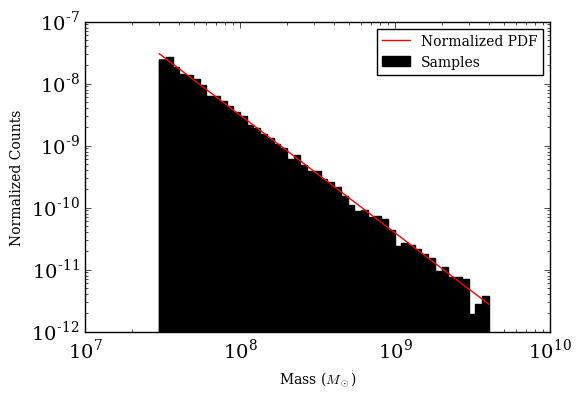

In [10]:
# Plot a histogram of the masses
bins = np.logspace(np.log10(MLOW),np.log10(MHIGH),50)
masses = np.concatenate(data['mass'])
n,b,p = plt.hist(masses,bins=bins,log=True,normed=True, label='Samples'); plt.gca().set_xscale('log')

# Plot the pdf normalized over the observable mass range
m,mp,mm,mmp = create_mass_array()
norm = simps(dP_dm_conv(mm,mmp,ALPHA,sigma=SIGMA),mp)
plt.plot(b,dP_dm_true(b,alpha=ALPHA)/norm,label='Normalized PDF')

plt.legend(loc='upper right')
plt.xlabel(r"Mass ($M_\odot$)"); plt.ylabel("Normalized Counts")

## Validation Results

We now have everything in place to replicate the results from VK09. We start by generating the top right panel of Figure 1. This is a realization with:
* $n_l = 10$
* $f = 0.025$
* $\alpha = 1.9$
* $M_{\rm low} = 3\times 10^7$
* $\sigma_m = 0$

Rather than doing a full MCMC chain, we choose just to scan the likelihood.

In [11]:
FRAC=0.005; ALPHA=1.9; MLOW=0.3e8; SIGMA=0
nlens=10; seed = 1
np.random.seed(seed)
fracs = np.linspace(0.001,0.03,151)
alphas = np.linspace(1.0,3.0,51)

In [12]:
data = simulate(nlens,alpha=ALPHA, frac=FRAC, sigma=SIGMA)
loglikes = np.array([LogLike(data,a,fracs) for a in alphas])
loglikes -= loglikes.max()
loglikes = loglikes.T

/usr/local/anaconda2/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in divide
/usr/local/anaconda2/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in divide


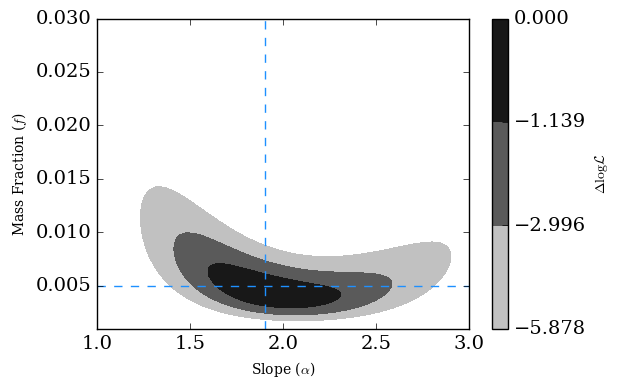

In [13]:
# Note the typo in VK09's definition of the 3 sigma p-value
levels = -stats.chi2.isf([0.0028,0.05,0.32,1.0],2)/2.
plt.contourf(alphas,fracs,loglikes,levels=levels,cmap='binary')
plt.axvline(ALPHA,ls='--',c='dodgerblue')
plt.axhline(FRAC,ls='--',c='dodgerblue')
plt.colorbar(label=r'$\Delta \log {\cal L}$')
plt.xlabel(r'Slope ($\alpha$)')
plt.ylabel(r'Mass Fraction ($f$)')

As an extended validation, we attempt to reproduce Figure 3 from VK09.

/usr/local/anaconda2/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in divide
/usr/local/anaconda2/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in divide


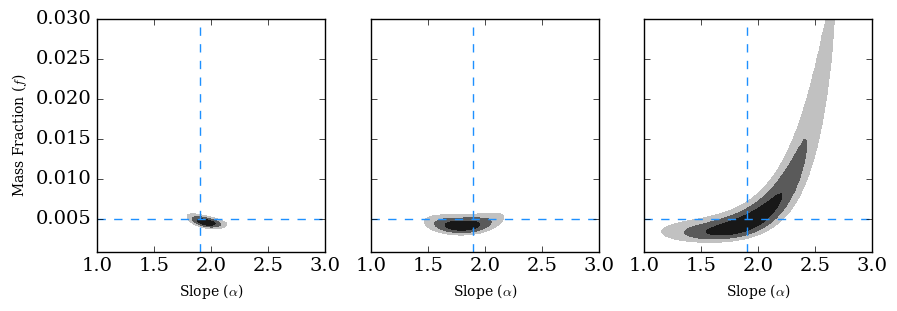

In [14]:
FRAC=0.005; ALPHA=1.9; SIGMA=0
nlens=200; seed = 0

fracs = np.linspace(0.001,0.03,151)
alphas = np.linspace(1.0,3.0,51)
fig,axes = plt.subplots(1,3,figsize=(10,3),sharey=True)
for i,m in enumerate([0.3e8,1.0e8,3e8]):
    MLOW = m
    data = simulate(nlens,alpha=ALPHA, frac=FRAC, sigma=SIGMA)
    loglikes = np.array([LogLike(data,a,fracs) for a in alphas])
    loglikes -= loglikes.max()
    loglikes = loglikes.T
    plt.sca(axes[i])
    plt.contourf(alphas,fracs,loglikes,levels=levels,cmap='binary')
    plt.axvline(ALPHA,ls='--',c='dodgerblue')
    plt.axhline(FRAC,ls='--',c='dodgerblue')
    plt.xlabel(r'Slope ($\alpha$)')
    if i == 0: plt.ylabel(r'Mass Fraction ($f$)')